# Searching for Bilingual Features inside Gemma's Models using Gemma Scope and SAE-Lens

In [1]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens sae-dashboard --quiet
    %pip install google-cloud --quiet
    %pip install google-cloud-secret-manager --quiet
    %pip install datasets --quiet
    %pip install circuitsvis --quiet
    %pip install transformers --quiet
    %pip install huggingface_hub --quiet
    %pip install plotly --quiet
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.6 MB/s eta 0:00:00
 

In [2]:
from google.cloud import secretmanager

def get_secret(secret_name: str, version = 1):
  secret_client = secretmanager.SecretManagerServiceClient()
  secret_name = f"projects/793924325008/secrets/{secret_name}/versions/{version}"
  response = secret_client.access_secret_version(request={"name": secret_name})
  return response.payload.data.decode("UTF-8")



In [3]:
from huggingface_hub import login

# Both Gemma 2B weights and the SAE weights are stored in HF. So we need to login first to it
hf_token = get_secret('HF_TOKEN')
login(token=hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [22]:
LLM_MODEL = "gemma-2-2b" # We will use Gemma 2B on its base pretrained form (no instruction tuning)
SAE_MODEL = "gemma-scope-2b-pt-res-canonical" # We'll use Sparse Autoencoders Trained on the Residual Stream of the Gemma 2 2B model

In [23]:
# from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
# get_pretrained_saes_directory()[SAE_MODEL].saes_map

In [24]:
SAE_ID = "layer_20/width_16k/canonical" # We'll first use the smaller SAE (16k features) in a somewhat deep layer (20th layer)

# At start this is a somewhat arbitrary choice
# I Used neuronpedia with a spanish prompt i got from the top of my mind
# to see how easy or hard it would be to find multilingual features
# It was actually quite easy.
# See: https://www.neuronpedia.org/gemma-2-2b/?sourceSet=gemmascope-res-16k&selectedLayers=[%2220-gemmascope-res-16k%22]&sortIndexes=[]&ignoreBos=true&q=Hoy%20tengo%20ganas%20de%20ir%20por%20un%20helado%20en%20la%20tarde
# FEATURE 2647 (INSTANCES OF "TODAY"): https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/2647
# FEATURE 4863 (INSTANCES OF "GO"): https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/4863
# FEATURE 6321 (RELATED TO INTENTION): https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6321

# Probably thanks to the training dataset language distribution, is clear that this features activate way more for the english versions. Their logits in the
# random spanish prompt i came up with were usually 40% less than the english counterparts
# But at least is evident that it should easy to find multilingual features.


In [25]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer

model = HookedSAETransformer.from_pretrained(LLM_MODEL, device = device)

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = SAE_MODEL, # <- Release name
    sae_id = SAE_ID, # <- SAE id (not always a hook point!)
    device = device
)

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [145]:
from transformer_lens.utils import test_prompt

prompt = "Ser o no ser, esa es la pregunta. Es una celebre frase que apareció en un libro de William"
answer = "Shakespeare"

# Show that the model can confidently predict the next token.
test_prompt(prompt, answer, model)

Tokenized prompt: ['<bos>', 'Ser', ' o', ' no', ' ser', ',', ' esa', ' es', ' la', ' pregunta', '.', ' Es', ' una', ' celebre', ' frase', ' que', ' apareció', ' en', ' un', ' libro', ' de', ' William']
Tokenized answer: [' Shakespeare']


Performance on answer token:
Rank: 0        Logit: 16.66 Prob: 38.98% Token: | Shakespeare|

Top 0th token. Logit: 16.66 Prob: 38.98% Token: | Shakespeare|
Top 1th token. Logit: 15.02 Prob:  7.55% Token: | James|
Top 2th token. Logit: 14.88 Prob:  6.56% Token: | Goldman|
Top 3th token. Logit: 14.85 Prob:  6.36% Token: | Faulkner|
Top 4th token. Logit: 14.61 Prob:  5.04% Token: | Somerset|
Top 5th token. Logit: 14.53 Prob:  4.63% Token: | Gold|
Top 6th token. Logit: 14.35 Prob:  3.88% Token: | Blake|
Top 7th token. Logit: 13.99 Prob:  2.70% Token: | Make|
Top 8th token. Logit: 13.75 Prob:  2.13% Token: | Haz|
Top 9th token. Logit: 13.37 Prob:  1.46% Token: | Sar|


Ranks of the answer tokens: [(' Shakespeare', 0)]

In [ ]:
sae.cfg.neuronpedia_id

'gemma-2-2b/20-gemmascope-res-16k'

In [146]:
from IPython.display import IFrame

# get a random feature from the SAE
feature_idx = 2647

html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gpt2-small", sae_id="7-res-jb", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

# Neuronpedia names are usually different to the ones in HF/SAE_Lens
neuronpedia_sae, neuronpedia_id = sae.cfg.neuronpedia_id.split("/")
html = get_dashboard_html(sae_release = neuronpedia_sae, sae_id=neuronpedia_id, feature_idx=feature_idx)
IFrame(html, width=1200, height=600)

## A Sistematic Method for the Descovering of Multilingual Features in a Sparse AutoEncoder

In [147]:
# Dataset
from datasets import load_dataset

ds = load_dataset("Helsinki-NLP/opus_books", "en-es")


Generating train split:   0%|          | 0/93470 [00:00<?, ? examples/s]

In [148]:
ds["train"][0:5]["translation"]

[{'en': 'Source: Project GutenbergAudiobook available here',
  'es': 'Source: Wikisource & librodot.com'},
 {'en': 'Sense and Sensibility', 'es': 'SENTIDO Y SENSIBILIDAD'},
 {'en': 'Jane Austen', 'es': 'JANE AUSTEN'},
 {'en': 'CHAPTER 1', 'es': 'CAPITULO I'},
 {'en': 'The family of Dashwood had long been settled in Sussex.',
  'es': 'La familia Dashwood llevaba largo tiempo afincada en Sussex.'}]

In [149]:
# We have ~25.3M sample pairs of english-spanish equivalent sentences.
ds["train"].dataset_size

25291663

#### Search Procedure

##### Step 1: Gather a dataset of SAE feature activations

* Get a random sample of our dataset (will use only 500 for memory reasons)
* For each sample, run it through the HookedTransformer with the SAE active. Capture the SAEs activation for all its 16k features for all the 500 * 2 samples.

##### Step 2: Analyze each individual feature in search for multilinguality

* If a feature is multi


### Generate random sample

In [150]:
sample_size = 500
sample_ds = ds["train"].shuffle(seed=42).select(range(sample_size))
sample_ds

Dataset({
    features: ['id', 'translation'],
    num_rows: 500
})

In [151]:
sample_ds[0]

{'id': '60296',
 'translation': {'en': 'Kitty, on the contrary, was more active than usual and even more animated.',
  'es': 'Kitty, al contrario, estaba más activa a incluso más animada que nunca.'}}

In [152]:
def tokenize_dataset(example):
  # tokens = {}
  raw_text_es, raw_text_en = example["translation"]["es"], example["translation"]["en"]
  example["tokens"] = model.to_tokens([raw_text_es, raw_text_en])
  example["str_tokens"] = dict(es=model.to_str_tokens(raw_text_es, prepend_bos=True),
                               en=model.to_str_tokens(raw_text_en, prepend_bos=True))

  example["len_tokens"] = 2 * example["tokens"].size(-1)
  return example

sample_ds = sample_ds.with_format("torch")
sample_ds = sample_ds.map(tokenize_dataset)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [153]:
total_tokens = sum(sample_ds["len_tokens"])
total_activations = sae.cfg.d_sae * total_tokens
print(f"{total_tokens=}")
print(f"{total_activations=}")

# A torch.float32 is 32 bits
total_bits = total_activations * 32
# there are approx 8*10^9 bits in a GB (strictly is 8*2ˆ30)
required_gbs = total_bits / (8*2**30)
print(f"{required_gbs=:.2f} GBs")

total_tokens=tensor(34098)
total_activations=tensor(558661632)
required_gbs=2.08 GBs


In [154]:
sample_ds[0]

{'id': '60296',
 'translation': {'en': 'Kitty, on the contrary, was more active than usual and even more animated.',
  'es': 'Kitty, al contrario, estaba más activa a incluso más animada que nunca.'},
 'tokens': tensor([[     2,  91739, 235269,    717,  45234, 235269,  20964,   3267,  83923,
             476,  28308,   3267, 214076,    907,  19266, 235265,      0],
         [     2,  91739, 235269,    611,    573,  20599, 235269,    729,    978,
            6066,   1178,  11653,    578,   1693,    978,  24412, 235265]]),
 'str_tokens': {'en': ['<bos>',
   'Kitty',
   ',',
   ' on',
   ' the',
   ' contrary',
   ',',
   ' was',
   ' more',
   ' active',
   ' than',
   ' usual',
   ' and',
   ' even',
   ' more',
   ' animated',
   '.'],
  'es': ['<bos>',
   'Kitty',
   ',',
   ' al',
   ' contrario',
   ',',
   ' estaba',
   ' más',
   ' activa',
   ' a',
   ' incluso',
   ' más',
   ' animada',
   ' que',
   ' nunca',
   '.']},
 'len_tokens': tensor(34)}

In [155]:
def get_sae_activations(example):
  sae_features_hook = f"{sae.cfg.hook_name}.hook_sae_acts_post"
  sae_features = model.run_with_cache_with_saes(example["tokens"],
                                                saes=[sae],
                                                stop_at_layer = sae.cfg.hook_layer + 1)[1][sae_features_hook]
  example["sae_features"] = sae_features
  return example

sample_ds = sample_ds.map(get_sae_activations)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [156]:
sample_ds["sae_features"][0].sort(descending=True)

torch.return_types.sort(
values=tensor([[[2028.8062,  781.3953,  534.8607,  ...,    0.0000,    0.0000,
             0.0000],
         [  63.7494,   63.5215,   58.5139,  ...,    0.0000,    0.0000,
             0.0000],
         [  82.0480,   52.1581,   45.1269,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [  77.2953,   62.9744,   40.5939,  ...,    0.0000,    0.0000,
             0.0000],
         [  98.6217,   65.0866,   65.0742,  ...,    0.0000,    0.0000,
             0.0000],
         [  67.2629,   51.5099,   34.9140,  ...,    0.0000,    0.0000,
             0.0000]],

        [[2028.8062,  781.3953,  534.8607,  ...,    0.0000,    0.0000,
             0.0000],
         [  63.7494,   63.5215,   58.5139,  ...,    0.0000,    0.0000,
             0.0000],
         [  82.0480,   52.1581,   45.1269,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [  67.4167,   54.3022,   50.9910,  ...,    0.0000,    0.0000,
             0.0000],
        

In [157]:
sample_ds.push_to_hub("diegomezp/gemmascope_bilingual_activations", commit_message="Included tokenization")

Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/545 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/diegomezp/gemmascope_bilingual_activations/commit/33a1ef46d9d7bc2dce4b4680a318245dd5a16680', commit_message='Included tokenization', commit_description='', oid='33a1ef46d9d7bc2dce4b4680a318245dd5a16680', pr_url=None, pr_revision=None, pr_num=None)

### Identify potential Multilingual features

For ***each feature*** look at the activation pattern across example pairs.

A multilingual feature should have many *double activations* (it should activate for both the english and spanish version of the same sentence).

### How to test that the identified candidates are actually modeling a single concept across languages?

* Do the activated pairs refer to a single concept?
* Can we use embedding models and cosine similarity as a proxy for *same conceptness*?
* ???


- Top examples from neuronpedia
- Chatgpt syntetics examples


In [158]:
from datasets import load_dataset
sample_ds = load_dataset("diegomezp/gemmascope_bilingual_activations").with_format("torch")
sample_ds = sample_ds["train"]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [161]:
sample_ds[0]["str_tokens"]["es"]

['<bos>',
 'Kitty',
 ',',
 ' al',
 ' contrario',
 ',',
 ' estaba',
 ' más',
 ' activa',
 ' a',
 ' incluso',
 ' más',
 ' animada',
 ' que',
 ' nunca',
 '.']

In [5]:
activation_tensor = torch.nested.nested_tensor(sample_ds["sae_features"]).to_padded_tensor(0.0)
print(f"Activation Tensor Size: {activation_tensor.size()}")

/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


Activation Tensor Size: torch.Size([500, 2, 226, 16384])


Quick Explainer of the prior tensor:

The size (500, 2, 226, 16384) corresponds to:

* 500 sample pairs
* 2 Languages. First is spanish, second is english, i.e., dim1=0=ES, dim1=1=EN
* 226 tokens per padded sample. Samples shorter than 226 tokens were padded with zeros (226 was the max seq length of the dataset). Also, the token at pos 0 is the BOS token (begining of sequence)
* 16384 feature activations in our SAE

## Activation Statistics

We will first see how each of the 16k features reacted to the dataset examples, as a whole and also per language. We'll set some thresholds for the feature activation logits, to also see ***how much*** they activated

In [6]:
def get_single_lang_statistics(activation_tensor: torch.tensor) -> dict:
  """
  Input:
    activation_tensor (torch.tensor float32): Tensor of size (samples, tokens, features)

  Output:
    (dict) : {
        "mean": {
          "value": float,
          "series": tensor size(|features|)
        },
        "quantil_0.05": # same structure as mean,
        "quantil_0.25": # same,
        "quantil_0.50": # same,
        "quantil_0.75": # same,
        "quantil_0.95": # same,
      }
  """
  s, t, f = activation_tensor.size()
  # Get quantils only for those logits > 0
  activation_logits = activation_tensor[activation_tensor > 0]
  mean_act = activation_logits.mean()
  quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
  quantiles_values = torch.quantile(activation_logits, torch.tensor(quantiles))

  thresholds = {"mean": mean_act}
  thresholds.update({f"quantil_{q}": v for q, v in zip(quantiles, quantiles_values)})
  response = dict()
  max_activations = activation_tensor.max(dim=1).values # size (s, f)

  for name, threshold in thresholds.items():
    response[name] = dict(value=threshold.item())
    final_activations = (max_activations > threshold).to(float).mean(dim=0) # size f
    response[name]["series"] = final_activations.sort(descending=True).values
  return response

def get_activation_statistics(activation_tensor: torch.tensor) -> dict:
  """
  Both globally and for each language dimension we will get as much as 4 series
  of size |features|. Each of those series will represent what percentage of
  the samples had at least one activation of a given feature.
  The ordering of the features in such tensor will also be returned, and we will
  use quantiles and mean for setting the activation threshold:

  Input:
    activation_tensor (torch.tensor): Tensor of size (samples, languages, tokens, features)

  Response:
    (dict) : {
      "stats: {
          "global": {
            "mean": {
              "value": float,
              "series": tensor size(|features|)
            },
            "quantil_0.05": # same structure as mean,
            "quantil_0.25": # same,
            "quantil_0.50": # same,
            "quantil_0.75": # same,
            "quantil_0.95": # same,
          },
          "lang_0": # Same structure as before,
          ...
          "lang_n": # Same as before
        }
      }
  """
  assert len(activation_tensor.size()) == 4, ("ActivationTensor must have 4 dims"
                                        "(samples, languages, tokens, features)")
  s, l, t, f = activation_tensor.size()
  response = dict()
  response["stats"] = dict()
  response["stats"]["global"] = get_single_lang_statistics(activation_tensor.reshape(-1, t, f))

  for idx in range(l):
    response["stats"][f"lang_{idx}"] = get_single_lang_statistics(activation_tensor[:, idx, :, :])

  return response


In [7]:
activation_stats = get_activation_statistics(activation_tensor[:, :, 1:, :]) # Ignoring BOS token

In [8]:
import plotly.graph_objects as go
import numpy as np


# Determine the number of groups and tensors
num_groups = len(activation_stats["stats"])
num_tensors = len(activation_stats["stats"]["global"])

titles = {
    "global": "Percentage of samples that each feature activated (ordered)",
    "lang_0": "Percentage of Spanish samples that each feature activated (ordered)",
    "lang_1": "Percentage of English samples that each feature activated (ordered)"
          }

# Loop through each group and its tensors
for col, (group_name, group_data) in enumerate(activation_stats["stats"].items()):
  fig = go.Figure()
  for series_name, series_data in group_data.items():
    fig.add_trace(go.Scatter(
        x=np.arange(series_data["series"].size(0)),  # X-axis: indices of tensor
        y=series_data["series"].numpy(),             # Y-axis: tensor values
        mode='lines',          # Line plot
        name=f"{series_name}={series_data['value']:.2f}",        # Name for the legend
        showlegend=True
    ))

  # Update layout
  fig.update_layout(
      title=titles[group_name],
      xaxis_title='SAE Features',
      yaxis_title='Percentage of Samples they Activated for',
      legend_title='Activation Threshold',
      template='plotly_white',
      xaxis_type="log"
  )

  # Show the figure
  fig.show()

# How to get candidates for interpretable bilingual features?

We can see quite consistent activation patterns and intencities across languages. Could this be a hint that most features are *bilingual* already?

At this point we do not really know. To explore more in this direction, we will try get *interpretable bilingual candidate features*. For this, we will try to assign some form of loss that should serve as a, hopefuly decent, proxy to obtain those features most likely to be bilingual but also interpretable.


The intuition is as follows:

* **Bilingual Component:** We should expect for a bilingual feature that when it does in fact activate, it will do it for both the enlgish and spanish samples mostly with the same intensity.
* **Interpretability Component:** If we want any hopes of interpretability, we will first try to find features that activate only for a small subset of the whole dataset. As we saw previously, there are thousands of features that activate for a large portion of the dataset. There is little hope for easy interpretability on those, so we will focus on the ones with small (but sufficient) number of activations.

Now, how to actually get a function for each of the components above and how to combine them is the hard part.

## Bilingual Loss

Let's start with some notation.

Let's say we have our whole dataset $D$ which is a disjoint union of $D_{es}$ and $D_{en}$, with, clearly, $|D_{es}| = |D_{en}| = n $, i.e, english and spanish datasets have the same size. Let $(d_{es}^k, d_{en}^k)$ be the natural k-th pair of spanish-english samples.

Let $d\_sae$ be the number of features we have for our SAE

Let $f$ be the composition of our model up to the hooked layer and our SAE encoder such that $f(d) \in R^{ctx\_size}\times R^{d\_sae}$ is the SAE feature activations for dataset example $d$ and $ctx\_size$ is the token length of example $d$.

Then, for each feature $F_i$ with $i \in [0, d\_sae-1]$, we can define a bilingual scoring function $BF(\cdot)$ by converting the activation vector for each language into a distribution with a ***softmax*** and then applying some symmetric measure of distance like the ***Jensen-Shannon divergence***. Formally:

Let

$$
q^i_{lang} := [max(f(d_{lang}^0)_i), \cdots, max(f(d_{lang}^n)_i)]^T \in R^{d\_sae}
$$

With $lang \in \{en, es\}$ and $i \in [0, d\_sae-1]$ being the corresponding maximum activation logit-vector of the feature $F_i$ for the language $lang$.

Then:

$$
BF(F_i) := JSD(softmax(q^i_{es}), softmax(q^i_{en}))
$$

With $JSD$ being the ***Jensen-Shannon divergence*** given by:


$$
JSD(p, q) := \frac{1}{2} D_{KL}(p | \textbf{M}) +  \frac{1}{2} D_{KL}(q | \textbf{M})
$$

Where $\textbf{M}$ is the mixture distribution $\frac{1}{2}(p + q)$ and $D_{KL}$ is the standar ***Kullback-Leibler divergence***



> **Random idea:** Can we force multilinguality in the SAEs by training them with multilingual samples and using the above loss (batched clearly) as complementary to the reconstruction and sparsity losses?

The prior metric gives us zeros when our feature is perfectly bilingual (activates not only in the same samples but with the same magnitude). With this definition, things like completely dead features (that produce zeros for all tokens) are perfectly bilingual (i mean, i guess they are). We might need to filter those out when doing our analysis.


## Sort-of Interpretability Loss

We also do not want those features that activate too many times, they might be doing very important processing internally but are extremely hard to interpret, or, on the other hand, are boring (imagine a feature for pronouns like he, him, she, her, él, ella, ellos, etc), those will probably activate a lot, but won't bring anything too interesting to our analysis. So, let's borrow some ideas from Information Retrieval. We want features that activate for few documents but when they do, they do it greatly. Here we can adapt the concept of idf (Inverse Document Frequency) to suit our need to our new idaf (Inverse Document Activation Frequency). The **idaf** term of a given feature will be the inverse of how many times such feature activated for the whole corpus. Formally:

$$
idaf(F_i) := \frac{|D|}{\sum_{d \in D} \textbf{1}_{max(f(d)) > 0}}
$$

> Note that a feature with zero activations in the whole set will cause a division by zero error. That is another reason we need to filter those out first.

And the final score for a given feature $F_i$ will be:

$$
Bilingual\_Interpretability(F_i) := BF(F_i) + \beta \cdot idaf(F_i)
$$

With $\beta$ a custom parameter so we can get both halfs to comparable ranges.




In [9]:
es_dead_features = ((activation_tensor[:, 0, 1:, :].max(dim=1).values > 0).sum(0) == 0)
en_dead_features = ((activation_tensor[:, 1, 1:, :].max(dim=1).values > 0).sum(0) == 0)
dead_features = es_dead_features | en_dead_features

In [10]:
en_dead_features.sum()

tensor(3737)

In [11]:
dead_features.sum()

tensor(5137)

In [12]:
import torch.nn.functional as F

def ur_kldiv(input: torch.tensor, target: torch.tensor, dim=0) -> torch.tensor:
  return target * (target.log() - input.log())



def JSD(p_logits: torch.tensor, q_logits: torch.tensor, dim=0) -> torch.tensor:
  # We will normalize them for numerical reasons
  p, q = p_logits.to(torch.float64), q_logits.to(torch.float64)
  p = p * 100 / p.max()
  q = q * 100 / q.max()


  p = p.softmax(dim=dim)
  q = q.softmax(dim=dim)
  m = 0.5 * (p + q)

  jsd = 0.5 * (ur_kldiv(p, m).mean(dim=0) + ur_kldiv(q, m).mean(dim=0))
  return jsd

In [53]:
es_acts = activation_tensor[:, 0, 1:, :].max(dim=1).values # From 1: in third dim to filter-out BOS
en_acts = activation_tensor[:, 1, 1:, :].max(dim=1).values

jsd = JSD(es_acts, en_acts)

In [54]:
def Idaf(activations):
  d, l, t, f = activations.size()
  idaf = (d*l) / (activations.view(-1, t, f).max(dim=1).values > 0).sum(0)
  idaf = torch.where(( (d*l) / idaf) < 10, 1.0, idaf)
  return - idaf

idaf = Idaf(activation_tensor[:, :, 1:, :])

In [143]:
# The idea is to scale m_idaf such that its full range |max - min| is less
# than the distance between the top jsd and the 300th place jsd.
# i.e. the m_idaf term will, at most, change the positions 300 places up or down
# in the top positions while leaving the last ones nearly untouched
# Is like we are using m_idaf as a reranker for our jsd initial scoring
beta_num = -(jsd[~dead_features].sort(descending=False).values[300] - jsd[~dead_features].min()).item()
beta = beta_num / (idaf[~dead_features].max() - idaf[~dead_features].min())

In [56]:
BI = jsd + beta * idaf

In [122]:
unfiltered = BI.sort(descending=False)
mask = ~dead_features
idx_order = unfiltered.indices[mask[unfiltered.indices]]
idx_value = unfiltered.values[mask[unfiltered.indices]]
print(idx_order)
print(BI[idx_order[0]] == idx_value[0])

tensor([ 6530,  2009,  7502,  ..., 13915,  9873,  3422])
tensor(True)


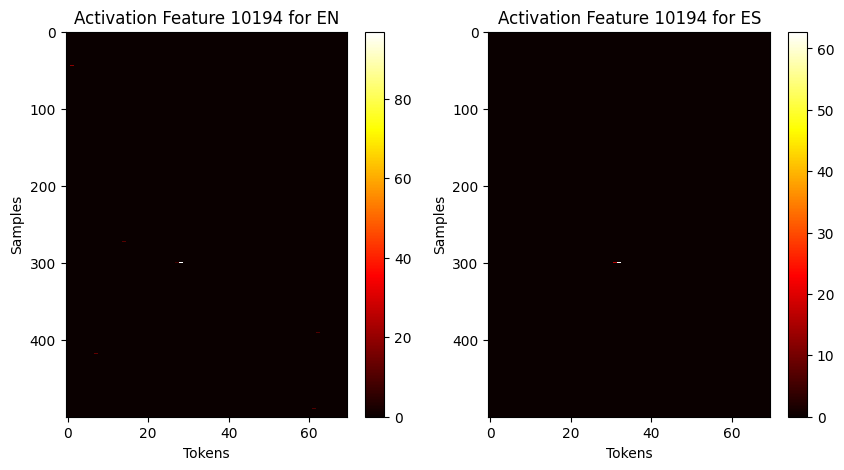

In [104]:
import matplotlib.pyplot as plt

n = 5
idx = idx_order[n]

display_ctxt_size = 70
fig_es = activation_tensor[:, 0, 1:, idx][:, :display_ctxt_size].numpy()
fig_en = activation_tensor[:, 1, 1:, idx][:, :display_ctxt_size].numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

im_en = axes[0].imshow(fig_en, cmap='hot', interpolation='nearest', aspect='auto')
im_es = axes[1].imshow(fig_es, cmap='hot', interpolation='nearest', aspect='auto')
fig.colorbar(im_en, ax=axes[0])
fig.colorbar(im_es, ax=axes[1])
axes[0].set_title(f"Activation Feature {idx} for EN")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Samples")
axes[1].set_title(f"Activation Feature {idx} for ES")
axes[1].set_xlabel("Tokens")
axes[1].set_ylabel("Samples")
plt.show()

In [162]:
from circuitsvis.tokens import colored_tokens
def get_tokens_and_acts(idx, ft_idx, ds=sample_ds, activations=activation_tensor, include_bos=False):
    start_idx = 0 if include_bos else 1
    str_tokens_es = ds[idx]["str_tokens"]["es"][start_idx:]
    str_tokens_en = ds[idx]["str_tokens"]["en"][start_idx:]

    token_act_es = activations[idx, 0, start_idx:(len(str_tokens_es)+1), ft_idx]
    token_act_en = activations[idx, 1, start_idx:(len(str_tokens_en)+1), ft_idx]


    t = ["<b>EN:</b>  "] + str_tokens_en + ["      <b>ES:</b>  "] + str_tokens_es
    a = [0] + token_act_en.tolist() + [0] + token_act_es.tolist()

    return colored_tokens(t, a)

greatest_act = activation_tensor[:, 1, 1:, idx].max(dim=-1).values.sort(descending=True)
get_tokens_and_acts(greatest_act.indices[0].item(), idx )

In [106]:
get_tokens_and_acts(greatest_act.indices[1].item(), idx )

In [107]:
get_tokens_and_acts(greatest_act.indices[3].item(), idx )

### Findings

#### Top features:
* **pos 0: 6530**: Not clearly interpretable
* **pos 1: 2009**: References to ***Quality*** and ***Calidad***
* **pos 2: 7502**: Related to ***Afganisthan*** / ***Afganistán***. Places inside the country, military organizations operating in it like the Taliban, etc
* **pos 3: 4275**: Feature for the name ***Andrew*** and the spanish equivalent ***Andrés***
* **pos 4: 2760**: References to ***Price*** / ***Precio***
* **pos 5: 10194**: Feature refering to the ***United States*** / ***Estados Unidos*** / ***US*** / ***America***
* **pos 6: 13963**: References to ***scientific measurements***.
* **pos 7: 2054**: References to ***February*** / ***Febrero*** and also the number ***2*** when is mentioned in the context of months
* **pos 8: 4762**: References to ***Degress*** / ***Grados Celcius*** / ***Temperatura atmosférica***
* **pos 9: 14036** Not clearly interpretable
* **pos 10: 12412**: References to ***Education*** / ***Educar*** / ***Instruir***

#### Other random findings
* **3767**: Feature for the color ***Blue*** and the spanish equivalent ***azul***
* **3052**: References for ***Wood*** and other constructions materials (Logs, Bricks, etc). Bilingual only for the spanish equivalent for wood, i.e, ***Madera***. (This looks like a candidate for looking into possible feature spliting with the larger version of this SAE)
* **5826**: References to celestial bodies and concepts (***Constellations***, ***Moon***, Luna, Meridianos, Orión, Áries, Hydra, Pegasus, Pegaso, etc)
* **8606**: Related to ***Angles*** / ***Ángulos***.
* **6826**: Related to ***Dance*** / ***Baile*** / ***Movement*** / ***Pasos*** and such.
* **6225**: Related to the title of ***Dr*** / ***Doctor***

#### Proper Names:

* **288**: Feature for the name ***Lucy***
* **4275**: Feature for the name ***Andrew*** and the spanish equivalent ***Andrés***
* **7457**: Feature for the name ***Henry***
* **12832**: Feature for the name ***Francis*** and the spanish equivalent ***Francisco*** (superposition present)

In [103]:
l = [6530, 2009, 7502, 4275, 2760, 10194, 13963, 2054, 4762, 14036, 12412, 288, 7457, 12832, 3767, 3052, 5826, 8606, 6826, 6225]
[torch.nonzero(idx_order == i, as_tuple=False)[0].item() for i in l]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 661, 127, 85, 202, 3315, 180, 109, 165, 144]

In [125]:
idx_value[0:12].tolist()

[4.442881974691051e-08,
 4.4428819793659613e-08,
 4.442882938285578e-08,
 4.442882967726952e-08,
 4.442889617501746e-08,
 4.442939963824309e-08,
 4.443070022280122e-08,
 4.443856851443512e-08,
 4.444231090244995e-08,
 4.4451682604606074e-08,
 4.445858874005918e-08,
 4.447403083541369e-08]

In [131]:

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(idx_value.size(0)),
    y=idx_value.numpy(),
    mode='lines'
))
fig.update_layout(
    title="Distribution of the Bilingual Interpretability Score on alive features",
    xaxis_title='SAE features post filtering of dead features',
    yaxis_title='BI loss value',
    template='plotly_white',
)
fig.show()